In [1]:
# Import Required Libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json
import pickle
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import custom modules (force reload)
sys.path.insert(0, os.getcwd())

# Clear any cached imports
if 'models' in sys.modules:
    del sys.modules['models']
if 'data_loading' in sys.modules:
    del sys.modules['data_loading']
if 'utility' in sys.modules:
    del sys.modules['utility']
if 'config' in sys.modules:
    del sys.modules['config']

from data_loading import WaferDataLoader
from utility import (setup_model_and_loaders, hyperparameter_tuning, 
                     evaluate_model, train_model)
from models import WaferResNet18  # Changed from WaferMobileNet to WaferResNet18
from config import TRANSFER_LEARNING_TUNING_GRID

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ All libraries imported successfully!")
print(f"Device: {device}")
print(f"\n✓ Using ResNet18 for Transfer Learning with layer freezing options")

Helper functions defined successfully!
✓ All libraries imported successfully!
Device: cuda

✓ Using ResNet18 for Transfer Learning with layer freezing options


## 1. Load and Prepare Data

In [2]:
# Load data using WaferDataLoader
print("Loading wafer defect dataset...")
loader = WaferDataLoader()

print(f"✓ Dataset loaded successfully!")
print(f"X shape: {loader.X.shape}")
print(f"y shape: {loader.y.shape}")
print(f"Number of classes: {loader.num_classes}")

# Get the data
X = loader.X.astype('float32')
y = loader.y

# Normalize data
X_min, X_max = X.min(), X.max()
X_normalized = (X - X_min) / (X_max - X_min) if X_max > X_min else X

print(f"\n✓ Normalization:")
print(f"  Original range: [{X_min}, {X_max}]")
print(f"  Normalized range: [{X_normalized.min():.4f}, {X_normalized.max():.4f}]")

# Reshape to 2D image format: (N, 2704) -> (N, 52, 52)
X_normalized = X_normalized.reshape(-1, 52, 52)

# Expand to 3 channels for ResNet18: (N, 52, 52) -> (N, 3, 52, 52)
# Replicate grayscale across 3 channels
X_normalized = np.repeat(X_normalized[:, np.newaxis, :, :], 3, axis=1)
print(f"\n✓ Reshaped for ResNet18: {X_normalized.shape}")

# Split into train/val/test (70% / 15% / 15%)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_normalized, y, test_size=0.3, random_state=42, stratify=y
)

X_val_full, X_test, y_val_full, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# ============================================================================
# USE SUBSET FOR FASTER TRAINING (adjust these values as needed)
# ============================================================================
TRAIN_SUBSET_SIZE = len(y_train_full)   # Use 5000 training samples (out of ~26k)
VAL_SUBSET_SIZE = len(y_val_full)     # Use 1500 validation samples (out of ~5.7k)
# Test set remains full for accurate evaluation

# Stratified sampling to maintain class distribution
from sklearn.model_selection import train_test_split as stratified_sample

if TRAIN_SUBSET_SIZE < len(y_train_full):
    X_train, _, y_train, _ = stratified_sample(
        X_train_full, y_train_full, 
        train_size=TRAIN_SUBSET_SIZE, 
        random_state=42, 
        stratify=y_train_full
    )
else:
    X_train, y_train = X_train_full, y_train_full

if VAL_SUBSET_SIZE < len(y_val_full):
    X_val, _, y_val, _ = stratified_sample(
        X_val_full, y_val_full, 
        train_size=VAL_SUBSET_SIZE, 
        random_state=42, 
        stratify=y_val_full
    )
else:
    X_val, y_val = X_val_full, y_val_full

print(f"\n✓ Data split complete (using SUBSETS for faster training):")
print(f"  Training set: {X_train.shape[0]} samples (subset from {len(y_train_full)})")
print(f"  Validation set: {X_val.shape[0]} samples (subset from {len(y_val_full)})")
print(f"  Test set: {X_test.shape[0]} samples (FULL - for accurate evaluation)")
print(f"\n⚡ Training speedup: ~{len(y_train_full)/len(y_train):.1f}x faster")

Loading wafer defect dataset...
Loading dataset from kagglehub cache...
✓ Dataset loaded successfully
  Wafer maps shape: (38015, 52, 52)
  Raw labels shape: (38015, 8)
✓ Labels converted to class indices
  Number of unique defect classes: 38
✓ Dataset loaded successfully!
X shape: (38015, 52, 52)
y shape: (38015,)
Number of classes: 38

✓ Normalization:
  Original range: [0.0, 3.0]
  Normalized range: [0.0000, 1.0000]

✓ Reshaped for ResNet18: (38015, 3, 52, 52)

✓ Data split complete (using SUBSETS for faster training):
  Training set: 26610 samples (subset from 26610)
  Validation set: 5702 samples (subset from 5702)
  Test set: 5703 samples (FULL - for accurate evaluation)

⚡ Training speedup: ~1.0x faster


## 2. Hyperparameter Tuning Grid

In [3]:
# Display tuning grid
print("="*80)
print("TRANSFER LEARNING (ResNet18) - HYPERPARAMETER TUNING GRID".center(80))
print("="*80)
print(f"\nTuning Grid:")
for param, values in TRANSFER_LEARNING_TUNING_GRID.items():
    print(f"  {param}: {values}")

# Explain freeze_layers parameter
print(f"\n📌 freeze_layers explanation:")
print(f"  0 = Train all layers (fine-tune entire network)")
print(f"  2 = Freeze layer1 + layer2 (train layer3, layer4, and classifier)")
print(f"  4 = Freeze all conv layers (only train classifier - fastest)")

total_combinations = np.prod([len(v) for v in TRANSFER_LEARNING_TUNING_GRID.values()])
print(f"\nTotal combinations to evaluate: {total_combinations}")
print("="*80)

           TRANSFER LEARNING (ResNet18) - HYPERPARAMETER TUNING GRID            

Tuning Grid:
  learning_rate: [0.001, 0.0001]
  batch_size: [32, 64]
  num_epochs: [15, 20]
  freeze_layers: [2, 4]
  dropout: [0.3]

📌 freeze_layers explanation:
  0 = Train all layers (fine-tune entire network)
  2 = Freeze layer1 + layer2 (train layer3, layer4, and classifier)
  4 = Freeze all conv layers (only train classifier - fastest)

Total combinations to evaluate: 16


## 3. Run Hyperparameter Tuning

In [4]:
# Hyperparameter tuning for Transfer Learning with ResNet18
print("=" * 80)
print("HYPERPARAMETER TUNING: Transfer Learning (ResNet18)")
print("=" * 80)

# Show model architecture info
print("\n📊 ResNet18 Architecture Info:")
test_model = WaferResNet18(num_classes=38, freeze_layers=0)
info = test_model.get_frozen_info()
print(f"  Total parameters: {info['total_params']:,}")

for fl in [0, 2, 4]:
    test_model = WaferResNet18(num_classes=38, freeze_layers=fl)
    info = test_model.get_frozen_info()
    print(f"  freeze_layers={fl}: {info['trainable_params']:,} trainable ({info['trainable_percent']:.1f}%)")
del test_model

print("\n✓ Starting hyperparameter tuning...")
print(f"  Total combinations: {np.prod([len(v) for v in TRANSFER_LEARNING_TUNING_GRID.values()])}")

tl_results = hyperparameter_tuning(
    model_class=WaferResNet18,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    param_grid=TRANSFER_LEARNING_TUNING_GRID,
    input_size=None,
    num_classes=loader.num_classes,
    device=str(device),
    verbose=True,
)

# Extract results dataframe and get top 5
if tl_results['best_params'] is not None:
    print(f"\n✓ Tuning complete! Tested {len(tl_results['results'])} hyperparameter combinations")
    tl_summary_df = tl_results['summary_df']
    tl_top5 = tl_summary_df.head(min(5, len(tl_summary_df)))

    print(f"\nTop {len(tl_top5)} Best Results:")
    display_cols = ['learning_rate', 'batch_size', 'num_epochs', 'freeze_layers', 'dropout', 'Val_Acc', 'Test_Acc']
    display_cols = [c for c in display_cols if c in tl_top5.columns]
    print(tl_top5[display_cols].to_string(index=False))
    
    print(f"\n✓ Best Model Performance:")
    print(f"  Validation Accuracy: {tl_results['best_val_acc']:.4f}")
    print(f"  Test Accuracy: {tl_results['best_test_acc']:.4f}")
else:
    print(f"\nERROR: All hyperparameter combinations failed!")
    if tl_results['results']:
        print(f"First result: {tl_results['results'][0]}")

HYPERPARAMETER TUNING: Transfer Learning (ResNet18)

📊 ResNet18 Architecture Info:
  Total parameters: 11,196,006
  freeze_layers=0: 11,196,006 trainable (100.0%)
  freeze_layers=2: 10,512,934 trainable (93.9%)
  freeze_layers=4: 19,494 trainable (0.2%)

✓ Starting hyperparameter tuning...
  Total combinations: 16

                  HYPERPARAMETER TUNING: Grid Search                  
Model: WaferResNet18
Total combinations to evaluate: 16
Parameters: learning_rate, batch_size, num_epochs, freeze_layers, dropout


[1/16] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 15, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 1.0171, Train Acc: 0.6840
  Val Loss: 0.4842, Val Acc: 0.8478
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.4690, Train Acc: 0.8542
  Val Loss: 0.3218, Val Acc: 0.9009
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.3436, Train Acc: 0.8970
  Val Loss: 0.3169, Val Acc: 0.9095
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.2943, Train Acc: 0.9131
  Val Loss: 0.3102, Val Acc: 0.9125
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2564, Train Acc: 0.9253
  Val Loss: 0.2593, Val Acc: 0.9260
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.2262, Train Acc: 0.9346
  Val Loss: 0.2167, Val Acc: 0.9398
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.2067, Train Acc: 0.9403
  Val Loss: 0.2516, Val Acc: 0.9307
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.1845, Train Acc: 0.9472
  Val Loss: 0.2356, Val Acc: 0.9330
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.1692, Train Acc: 0.9507
  Val Loss: 0.2153, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.1443, Train Acc: 0.9581
  Val Loss: 0.2184, Val Acc: 0.9397
  Patience: 1/5


Epoch 11/15:
  Train Loss: 0.1369, Train Acc: 0.9617
  Val Loss: 0.2174, Val Acc: 0.9469
  Patience: 2/5


Epoch 12/15:
  Train Loss: 0.1254, Train Acc: 0.9629
  Val Loss: 0.2420, Val Acc: 0.9351
  Patience: 3/5


Epoch 13/15:
  Train Loss: 0.1055, Train Acc: 0.9696
  Val Loss: 0.2621, Val Acc: 0.9360
  Patience: 4/5


Epoch 14/15:
  Train Loss: 0.1079, Train Acc: 0.9687
  Val Loss: 0.2321, Val Acc: 0.9460
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.2153
Train Acc: 0.9687 | Val Acc: 0.9460 | Test Acc: 0.9388
✓ NEW BEST! (Val Acc: 0.9460)

[2/16] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 15, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.6605, Train Acc: 0.2558
  Val Loss: 1.8319, Val Acc: 0.4109
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.2012, Train Acc: 0.3250
  Val Loss: 1.7538, Val Acc: 0.4290
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.1629, Train Acc: 0.3334
  Val Loss: 1.7161, Val Acc: 0.4376
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.1630, Train Acc: 0.3349
  Val Loss: 1.6943, Val Acc: 0.4476
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.1391, Train Acc: 0.3392
  Val Loss: 1.6947, Val Acc: 0.4395
  Patience: 1/5


Epoch 6/15:
  Train Loss: 2.1640, Train Acc: 0.3379
  Val Loss: 1.7156, Val Acc: 0.4327
  Patience: 2/5


Epoch 7/15:
  Train Loss: 2.1625, Train Acc: 0.3380
  Val Loss: 1.6645, Val Acc: 0.4535
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1649, Train Acc: 0.3370
  Val Loss: 1.6848, Val Acc: 0.4321
  Patience: 1/5


Epoch 9/15:
  Train Loss: 2.1404, Train Acc: 0.3430
  Val Loss: 1.6953, Val Acc: 0.4376
  Patience: 2/5


Epoch 10/15:
  Train Loss: 2.1675, Train Acc: 0.3372
  Val Loss: 1.6783, Val Acc: 0.4412
  Patience: 3/5


Epoch 11/15:
  Train Loss: 2.1781, Train Acc: 0.3321
  Val Loss: 1.7165, Val Acc: 0.4260
  Patience: 4/5


Epoch 12/15:
  Train Loss: 2.1524, Train Acc: 0.3370
  Val Loss: 1.6880, Val Acc: 0.4469
  Patience: 5/5

Early stopping triggered at epoch 12

Loaded best model with validation loss: 1.6645
Train Acc: 0.3370 | Val Acc: 0.4469 | Test Acc: 0.4317

[3/16] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 1.0139, Train Acc: 0.6840
  Val Loss: 0.6274, Val Acc: 0.7850
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.4658, Train Acc: 0.8568
  Val Loss: 0.3154, Val Acc: 0.8997
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3523, Train Acc: 0.8918
  Val Loss: 0.2838, Val Acc: 0.9106
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.2948, Train Acc: 0.9130
  Val Loss: 0.2501, Val Acc: 0.9251
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.2633, Train Acc: 0.9228
  Val Loss: 0.2379, Val Acc: 0.9307
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.2272, Train Acc: 0.9333
  Val Loss: 0.2603, Val Acc: 0.9244
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.1988, Train Acc: 0.9417
  Val Loss: 0.2591, Val Acc: 0.9295
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.1793, Train Acc: 0.9486
  Val Loss: 0.2601, Val Acc: 0.9346
  Patience: 3/5


Epoch 9/20:
  Train Loss: 0.1590, Train Acc: 0.9544
  Val Loss: 0.2126, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.1546, Train Acc: 0.9545
  Val Loss: 0.2700, Val Acc: 0.9349
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.1364, Train Acc: 0.9605
  Val Loss: 0.2310, Val Acc: 0.9400
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.1193, Train Acc: 0.9660
  Val Loss: 0.2495, Val Acc: 0.9386
  Patience: 3/5


Epoch 13/20:
  Train Loss: 0.1193, Train Acc: 0.9660
  Val Loss: 0.2288, Val Acc: 0.9402
  Patience: 4/5


Epoch 14/20:
  Train Loss: 0.0931, Train Acc: 0.9723
  Val Loss: 0.2493, Val Acc: 0.9442
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.2126
Train Acc: 0.9723 | Val Acc: 0.9442 | Test Acc: 0.9346

[4/16] Testing: {'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.6498, Train Acc: 0.2517
  Val Loss: 1.8262, Val Acc: 0.4030
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1950, Train Acc: 0.3248
  Val Loss: 1.7345, Val Acc: 0.4276
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.1727, Train Acc: 0.3319
  Val Loss: 1.7496, Val Acc: 0.4265
  Patience: 1/5


Epoch 4/20:
  Train Loss: 2.1738, Train Acc: 0.3287
  Val Loss: 1.7065, Val Acc: 0.4309
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.1594, Train Acc: 0.3341
  Val Loss: 1.7015, Val Acc: 0.4355
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1543, Train Acc: 0.3402
  Val Loss: 1.6828, Val Acc: 0.4304
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1533, Train Acc: 0.3379
  Val Loss: 1.6917, Val Acc: 0.4348
  Patience: 1/5


Epoch 8/20:
  Train Loss: 2.1641, Train Acc: 0.3338
  Val Loss: 1.6876, Val Acc: 0.4330
  Patience: 2/5


Epoch 9/20:
  Train Loss: 2.1497, Train Acc: 0.3388
  Val Loss: 1.7180, Val Acc: 0.4302
  Patience: 3/5


Epoch 10/20:
  Train Loss: 2.1604, Train Acc: 0.3350
  Val Loss: 1.6644, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.1615, Train Acc: 0.3362
  Val Loss: 1.6619, Val Acc: 0.4411
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 2.1515, Train Acc: 0.3410
  Val Loss: 1.6989, Val Acc: 0.4398
  Patience: 1/5


Epoch 13/20:
  Train Loss: 2.1575, Train Acc: 0.3391
  Val Loss: 1.6767, Val Acc: 0.4474
  Patience: 2/5


Epoch 14/20:
  Train Loss: 2.1495, Train Acc: 0.3427
  Val Loss: 1.6636, Val Acc: 0.4455
  Patience: 3/5


Epoch 15/20:
  Train Loss: 2.1584, Train Acc: 0.3454
  Val Loss: 1.6650, Val Acc: 0.4437
  Patience: 4/5


Epoch 16/20:
  Train Loss: 2.1589, Train Acc: 0.3383
  Val Loss: 1.7330, Val Acc: 0.4262
  Patience: 5/5

Early stopping triggered at epoch 16

Loaded best model with validation loss: 1.6619
Train Acc: 0.3383 | Val Acc: 0.4262 | Test Acc: 0.4221

[5/16] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 0.9695, Train Acc: 0.7065
  Val Loss: 0.4113, Val Acc: 0.8609
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.4197, Train Acc: 0.8672
  Val Loss: 0.3399, Val Acc: 0.8946
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.3151, Train Acc: 0.9037
  Val Loss: 0.2880, Val Acc: 0.9142
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.2557, Train Acc: 0.9248
  Val Loss: 0.2470, Val Acc: 0.9241
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2195, Train Acc: 0.9324
  Val Loss: 0.2284, Val Acc: 0.9302
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.1932, Train Acc: 0.9404
  Val Loss: 0.2921, Val Acc: 0.9216
  Patience: 1/5


Epoch 7/15:
  Train Loss: 0.1806, Train Acc: 0.9460
  Val Loss: 0.2332, Val Acc: 0.9330
  Patience: 2/5


Epoch 8/15:
  Train Loss: 0.1556, Train Acc: 0.9533
  Val Loss: 0.2470, Val Acc: 0.9325
  Patience: 3/5


Epoch 9/15:
  Train Loss: 0.1369, Train Acc: 0.9594
  Val Loss: 0.2568, Val Acc: 0.9349
  Patience: 4/5


Epoch 10/15:
  Train Loss: 0.1343, Train Acc: 0.9581
  Val Loss: 0.2870, Val Acc: 0.9279
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 0.2284
Train Acc: 0.9581 | Val Acc: 0.9279 | Test Acc: 0.9278

[6/16] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 2.7315, Train Acc: 0.2471
  Val Loss: 1.8586, Val Acc: 0.4165
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.1047, Train Acc: 0.3433
  Val Loss: 1.7193, Val Acc: 0.4388
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.0297, Train Acc: 0.3605
  Val Loss: 1.6923, Val Acc: 0.4434
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.0152, Train Acc: 0.3619
  Val Loss: 1.6627, Val Acc: 0.4414
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.0058, Train Acc: 0.3643
  Val Loss: 1.6574, Val Acc: 0.4512
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 1.9942, Train Acc: 0.3675
  Val Loss: 1.6517, Val Acc: 0.4514
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0075, Train Acc: 0.3669
  Val Loss: 1.6583, Val Acc: 0.4514
  Patience: 1/5


Epoch 8/15:
  Train Loss: 1.9999, Train Acc: 0.3677
  Val Loss: 1.6307, Val Acc: 0.4574
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0003, Train Acc: 0.3687
  Val Loss: 1.6556, Val Acc: 0.4490
  Patience: 1/5


Epoch 10/15:
  Train Loss: 1.9962, Train Acc: 0.3725
  Val Loss: 1.6297, Val Acc: 0.4523
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0133, Train Acc: 0.3635
  Val Loss: 1.6316, Val Acc: 0.4500
  Patience: 1/5


Epoch 12/15:
  Train Loss: 2.0018, Train Acc: 0.3704
  Val Loss: 1.6551, Val Acc: 0.4486
  Patience: 2/5


Epoch 13/15:
  Train Loss: 2.0119, Train Acc: 0.3662
  Val Loss: 1.6311, Val Acc: 0.4521
  Patience: 3/5


Epoch 14/15:
  Train Loss: 1.9993, Train Acc: 0.3711
  Val Loss: 1.6280, Val Acc: 0.4597
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 2.0007, Train Acc: 0.3702
  Val Loss: 1.6221, Val Acc: 0.4544
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6221
Train Acc: 0.3702 | Val Acc: 0.4544 | Test Acc: 0.4501

[7/16] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 0.9592, Train Acc: 0.7102
  Val Loss: 0.4420, Val Acc: 0.8508
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.4277, Train Acc: 0.8638
  Val Loss: 0.3781, Val Acc: 0.8750
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3203, Train Acc: 0.9021
  Val Loss: 0.2831, Val Acc: 0.9141
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.2626, Train Acc: 0.9190
  Val Loss: 0.3008, Val Acc: 0.9141
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.2178, Train Acc: 0.9339
  Val Loss: 0.2409, Val Acc: 0.9290
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.1920, Train Acc: 0.9422
  Val Loss: 0.2317, Val Acc: 0.9386
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.1730, Train Acc: 0.9495
  Val Loss: 0.2946, Val Acc: 0.9163
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.1518, Train Acc: 0.9540
  Val Loss: 0.3032, Val Acc: 0.9146
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.1475, Train Acc: 0.9561
  Val Loss: 0.2597, Val Acc: 0.9239
  Patience: 3/5


Epoch 10/20:
  Train Loss: 0.1288, Train Acc: 0.9629
  Val Loss: 0.2910, Val Acc: 0.9274
  Patience: 4/5


Epoch 11/20:
  Train Loss: 0.1127, Train Acc: 0.9654
  Val Loss: 0.2502, Val Acc: 0.9370
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 0.2317
Train Acc: 0.9654 | Val Acc: 0.9370 | Test Acc: 0.9371

[8/16] Testing: {'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 2.7333, Train Acc: 0.2449
  Val Loss: 1.8518, Val Acc: 0.4102
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.1002, Train Acc: 0.3431
  Val Loss: 1.7311, Val Acc: 0.4353
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.0355, Train Acc: 0.3617
  Val Loss: 1.6883, Val Acc: 0.4495
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.0202, Train Acc: 0.3667
  Val Loss: 1.6809, Val Acc: 0.4472
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.0044, Train Acc: 0.3683
  Val Loss: 1.6725, Val Acc: 0.4437
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 1.9814, Train Acc: 0.3759
  Val Loss: 1.6699, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.0058, Train Acc: 0.3697
  Val Loss: 1.6248, Val Acc: 0.4590
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 1.9957, Train Acc: 0.3713
  Val Loss: 1.6577, Val Acc: 0.4432
  Patience: 1/5


Epoch 9/20:
  Train Loss: 2.0015, Train Acc: 0.3698
  Val Loss: 1.6451, Val Acc: 0.4483
  Patience: 2/5


Epoch 10/20:
  Train Loss: 1.9915, Train Acc: 0.3676
  Val Loss: 1.6158, Val Acc: 0.4525
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9992, Train Acc: 0.3703
  Val Loss: 1.6304, Val Acc: 0.4556
  Patience: 1/5


Epoch 12/20:
  Train Loss: 2.0130, Train Acc: 0.3637
  Val Loss: 1.6096, Val Acc: 0.4614
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9931, Train Acc: 0.3714
  Val Loss: 1.6217, Val Acc: 0.4590
  Patience: 1/5


Epoch 14/20:
  Train Loss: 1.9929, Train Acc: 0.3694
  Val Loss: 1.6172, Val Acc: 0.4556
  Patience: 2/5


Epoch 15/20:
  Train Loss: 1.9857, Train Acc: 0.3766
  Val Loss: 1.6317, Val Acc: 0.4523
  Patience: 3/5


Epoch 16/20:
  Train Loss: 1.9895, Train Acc: 0.3756
  Val Loss: 1.6269, Val Acc: 0.4548
  Patience: 4/5


Epoch 17/20:
  Train Loss: 1.9969, Train Acc: 0.3739
  Val Loss: 1.6088, Val Acc: 0.4625
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9977, Train Acc: 0.3673
  Val Loss: 1.6518, Val Acc: 0.4456
  Patience: 1/5


Epoch 19/20:
  Train Loss: 1.9960, Train Acc: 0.3703
  Val Loss: 1.6236, Val Acc: 0.4519
  Patience: 2/5


Epoch 20/20:
  Train Loss: 1.9863, Train Acc: 0.3714
  Val Loss: 1.6368, Val Acc: 0.4548
  Patience: 3/5

Loaded best model with validation loss: 1.6088
Train Acc: 0.3714 | Val Acc: 0.4548 | Test Acc: 0.4391

[9/16] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 15, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 1.5708, Train Acc: 0.6017
  Val Loss: 0.5181, Val Acc: 0.8248
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.5522, Train Acc: 0.8194
  Val Loss: 0.3786, Val Acc: 0.8793
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.3909, Train Acc: 0.8730
  Val Loss: 0.3094, Val Acc: 0.9027
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.3024, Train Acc: 0.9028
  Val Loss: 0.2858, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2366, Train Acc: 0.9225
  Val Loss: 0.2804, Val Acc: 0.9120
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.2063, Train Acc: 0.9348
  Val Loss: 0.2702, Val Acc: 0.9206
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.1673, Train Acc: 0.9458
  Val Loss: 0.2970, Val Acc: 0.9163
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.1502, Train Acc: 0.9530
  Val Loss: 0.2856, Val Acc: 0.9237
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.1175, Train Acc: 0.9618
  Val Loss: 0.2721, Val Acc: 0.9218
  Patience: 3/5


Epoch 10/15:
  Train Loss: 0.1029, Train Acc: 0.9671
  Val Loss: 0.2765, Val Acc: 0.9274
  Patience: 4/5


Epoch 11/15:
  Train Loss: 0.0855, Train Acc: 0.9713
  Val Loss: 0.3131, Val Acc: 0.9213
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 0.2702
Train Acc: 0.9713 | Val Acc: 0.9213 | Test Acc: 0.9185

[10/16] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 15, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 4.2103, Train Acc: 0.0906
  Val Loss: 2.7807, Val Acc: 0.2347
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 2.8478, Train Acc: 0.2031
  Val Loss: 2.2870, Val Acc: 0.3260
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.5099, Train Acc: 0.2607
  Val Loss: 2.0911, Val Acc: 0.3676
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.3382, Train Acc: 0.2933
  Val Loss: 1.9695, Val Acc: 0.3979
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.2366, Train Acc: 0.3121
  Val Loss: 1.8875, Val Acc: 0.4123
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.1652, Train Acc: 0.3310
  Val Loss: 1.8516, Val Acc: 0.4272
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.0953, Train Acc: 0.3459
  Val Loss: 1.7965, Val Acc: 0.4391
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.0586, Train Acc: 0.3530
  Val Loss: 1.7792, Val Acc: 0.4477
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0384, Train Acc: 0.3593
  Val Loss: 1.7439, Val Acc: 0.4509
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0144, Train Acc: 0.3676
  Val Loss: 1.7367, Val Acc: 0.4532
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0019, Train Acc: 0.3710
  Val Loss: 1.7092, Val Acc: 0.4562
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9788, Train Acc: 0.3768
  Val Loss: 1.6874, Val Acc: 0.4639
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.9616, Train Acc: 0.3820
  Val Loss: 1.6849, Val Acc: 0.4588
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.9574, Train Acc: 0.3783
  Val Loss: 1.6892, Val Acc: 0.4619
  Patience: 1/5


Epoch 15/15:
  Train Loss: 1.9465, Train Acc: 0.3814
  Val Loss: 1.6576, Val Acc: 0.4639
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6576
Train Acc: 0.3814 | Val Acc: 0.4639 | Test Acc: 0.4550

[11/16] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 1.5991, Train Acc: 0.5935
  Val Loss: 0.4755, Val Acc: 0.8411
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.5640, Train Acc: 0.8163
  Val Loss: 0.3571, Val Acc: 0.8846
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3930, Train Acc: 0.8736
  Val Loss: 0.3032, Val Acc: 0.9055
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.3091, Train Acc: 0.9027
  Val Loss: 0.3284, Val Acc: 0.8992
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.2445, Train Acc: 0.9230
  Val Loss: 0.2952, Val Acc: 0.9109
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.2070, Train Acc: 0.9327
  Val Loss: 0.2643, Val Acc: 0.9207
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.1657, Train Acc: 0.9479
  Val Loss: 0.2772, Val Acc: 0.9156
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.1534, Train Acc: 0.9514
  Val Loss: 0.3243, Val Acc: 0.9146
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.1282, Train Acc: 0.9582
  Val Loss: 0.2637, Val Acc: 0.9263
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.1030, Train Acc: 0.9670
  Val Loss: 0.2995, Val Acc: 0.9302
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.0905, Train Acc: 0.9704
  Val Loss: 0.2838, Val Acc: 0.9258
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.0818, Train Acc: 0.9737
  Val Loss: 0.3353, Val Acc: 0.9216
  Patience: 3/5


Epoch 13/20:
  Train Loss: 0.0742, Train Acc: 0.9763
  Val Loss: 0.3093, Val Acc: 0.9295
  Patience: 4/5


Epoch 14/20:
  Train Loss: 0.0674, Train Acc: 0.9785
  Val Loss: 0.4156, Val Acc: 0.9100
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.2637
Train Acc: 0.9785 | Val Acc: 0.9100 | Test Acc: 0.9115

[12/16] Testing: {'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 4.1487, Train Acc: 0.0903
  Val Loss: 2.7449, Val Acc: 0.2420
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 2.8424, Train Acc: 0.2048
  Val Loss: 2.2826, Val Acc: 0.3380
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.5163, Train Acc: 0.2574
  Val Loss: 2.0753, Val Acc: 0.3765
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.3503, Train Acc: 0.2912
  Val Loss: 1.9719, Val Acc: 0.4018
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.2387, Train Acc: 0.3158
  Val Loss: 1.8807, Val Acc: 0.4160
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.1568, Train Acc: 0.3284
  Val Loss: 1.8395, Val Acc: 0.4267
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1026, Train Acc: 0.3427
  Val Loss: 1.7823, Val Acc: 0.4369
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.0735, Train Acc: 0.3499
  Val Loss: 1.7647, Val Acc: 0.4493
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0452, Train Acc: 0.3540
  Val Loss: 1.7382, Val Acc: 0.4507
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.0023, Train Acc: 0.3711
  Val Loss: 1.7196, Val Acc: 0.4555
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 1.9935, Train Acc: 0.3705
  Val Loss: 1.7057, Val Acc: 0.4590
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9807, Train Acc: 0.3772
  Val Loss: 1.6992, Val Acc: 0.4581
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9631, Train Acc: 0.3768
  Val Loss: 1.6803, Val Acc: 0.4598
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9553, Train Acc: 0.3815
  Val Loss: 1.6811, Val Acc: 0.4628
  Patience: 1/5


Epoch 15/20:
  Train Loss: 1.9393, Train Acc: 0.3888
  Val Loss: 1.6546, Val Acc: 0.4707
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9284, Train Acc: 0.3888
  Val Loss: 1.6447, Val Acc: 0.4697
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9312, Train Acc: 0.3859
  Val Loss: 1.6588, Val Acc: 0.4676
  Patience: 1/5


Epoch 18/20:
  Train Loss: 1.9235, Train Acc: 0.3876
  Val Loss: 1.6643, Val Acc: 0.4676
  Patience: 2/5


Epoch 19/20:
  Train Loss: 1.9216, Train Acc: 0.3874
  Val Loss: 1.6442, Val Acc: 0.4698
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.9218, Train Acc: 0.3891
  Val Loss: 1.6395, Val Acc: 0.4686
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6395
Train Acc: 0.3891 | Val Acc: 0.4686 | Test Acc: 0.4599

[13/16] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 15, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 1.8864, Train Acc: 0.5714
  Val Loss: 0.5164, Val Acc: 0.8250
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.5441, Train Acc: 0.8230
  Val Loss: 0.3821, Val Acc: 0.8769
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.3682, Train Acc: 0.8805
  Val Loss: 0.3353, Val Acc: 0.8864
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.2757, Train Acc: 0.9129
  Val Loss: 0.3316, Val Acc: 0.8907
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2132, Train Acc: 0.9314
  Val Loss: 0.2909, Val Acc: 0.9113
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 0.1745, Train Acc: 0.9445
  Val Loss: 0.2874, Val Acc: 0.9118
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.1421, Train Acc: 0.9549
  Val Loss: 0.3314, Val Acc: 0.9072
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.1254, Train Acc: 0.9594
  Val Loss: 0.3483, Val Acc: 0.9016
  Patience: 2/5


Epoch 9/15:
  Train Loss: 0.0885, Train Acc: 0.9721
  Val Loss: 0.3619, Val Acc: 0.9130
  Patience: 3/5


Epoch 10/15:
  Train Loss: 0.0899, Train Acc: 0.9698
  Val Loss: 0.3258, Val Acc: 0.9190
  Patience: 4/5


Epoch 11/15:
  Train Loss: 0.0702, Train Acc: 0.9779
  Val Loss: 0.3588, Val Acc: 0.9137
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 0.2874
Train Acc: 0.9779 | Val Acc: 0.9137 | Test Acc: 0.9158

[14/16] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 15, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/15:
  Train Loss: 4.7823, Train Acc: 0.0598
  Val Loss: 3.1595, Val Acc: 0.1745
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 3.1615, Train Acc: 0.1629
  Val Loss: 2.5777, Val Acc: 0.2736
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 2.7334, Train Acc: 0.2252
  Val Loss: 2.2876, Val Acc: 0.3302
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 2.5105, Train Acc: 0.2649
  Val Loss: 2.1404, Val Acc: 0.3630
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 2.3602, Train Acc: 0.2950
  Val Loss: 2.0310, Val Acc: 0.3839
  ✓ New best validation loss!


Epoch 6/15:
  Train Loss: 2.2573, Train Acc: 0.3140
  Val Loss: 1.9592, Val Acc: 0.3941
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 2.1806, Train Acc: 0.3294
  Val Loss: 1.8908, Val Acc: 0.4104
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 2.1256, Train Acc: 0.3413
  Val Loss: 1.8742, Val Acc: 0.4172
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 2.0794, Train Acc: 0.3514
  Val Loss: 1.8155, Val Acc: 0.4309
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 2.0454, Train Acc: 0.3582
  Val Loss: 1.7956, Val Acc: 0.4356
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 2.0074, Train Acc: 0.3731
  Val Loss: 1.7798, Val Acc: 0.4418
  ✓ New best validation loss!


Epoch 12/15:
  Train Loss: 1.9844, Train Acc: 0.3765
  Val Loss: 1.7464, Val Acc: 0.4477
  ✓ New best validation loss!


Epoch 13/15:
  Train Loss: 1.9647, Train Acc: 0.3805
  Val Loss: 1.7332, Val Acc: 0.4537
  ✓ New best validation loss!


Epoch 14/15:
  Train Loss: 1.9502, Train Acc: 0.3831
  Val Loss: 1.7211, Val Acc: 0.4514
  ✓ New best validation loss!


Epoch 15/15:
  Train Loss: 1.9296, Train Acc: 0.3875
  Val Loss: 1.7080, Val Acc: 0.4544
  ✓ New best validation loss!

Loaded best model with validation loss: 1.7080
Train Acc: 0.3875 | Val Acc: 0.4544 | Test Acc: 0.4494

[15/16] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'freeze_layers': 2, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 1.8685, Train Acc: 0.5671
  Val Loss: 0.5183, Val Acc: 0.8202
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.5416, Train Acc: 0.8222
  Val Loss: 0.3920, Val Acc: 0.8723
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3712, Train Acc: 0.8793
  Val Loss: 0.3221, Val Acc: 0.8999
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.2878, Train Acc: 0.9085
  Val Loss: 0.3244, Val Acc: 0.8971
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.2234, Train Acc: 0.9288
  Val Loss: 0.3063, Val Acc: 0.9037
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.1770, Train Acc: 0.9425
  Val Loss: 0.2894, Val Acc: 0.9169
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.1409, Train Acc: 0.9548
  Val Loss: 0.3779, Val Acc: 0.8974
  Patience: 1/5


Epoch 8/20:
  Train Loss: 0.1116, Train Acc: 0.9636
  Val Loss: 0.3099, Val Acc: 0.9128
  Patience: 2/5


Epoch 9/20:
  Train Loss: 0.1033, Train Acc: 0.9655
  Val Loss: 0.3237, Val Acc: 0.9181
  Patience: 3/5


Epoch 10/20:
  Train Loss: 0.0832, Train Acc: 0.9732
  Val Loss: 0.3531, Val Acc: 0.9093
  Patience: 4/5


Epoch 11/20:
  Train Loss: 0.0731, Train Acc: 0.9758
  Val Loss: 0.2987, Val Acc: 0.9230
  Patience: 5/5

Early stopping triggered at epoch 11

Loaded best model with validation loss: 0.2894
Train Acc: 0.9758 | Val Acc: 0.9230 | Test Acc: 0.9150

[16/16] Testing: {'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'freeze_layers': 4, 'dropout': 0.3}
----------------------------------------------------------------------


Epoch 1/20:
  Train Loss: 4.7727, Train Acc: 0.0610
  Val Loss: 3.1086, Val Acc: 0.1899
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 3.1578, Train Acc: 0.1669
  Val Loss: 2.5569, Val Acc: 0.2888
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 2.7272, Train Acc: 0.2263
  Val Loss: 2.2914, Val Acc: 0.3415
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 2.5110, Train Acc: 0.2617
  Val Loss: 2.1331, Val Acc: 0.3660
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 2.3656, Train Acc: 0.2923
  Val Loss: 2.0229, Val Acc: 0.3916
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 2.2508, Train Acc: 0.3182
  Val Loss: 1.9504, Val Acc: 0.4081
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 2.1744, Train Acc: 0.3333
  Val Loss: 1.9053, Val Acc: 0.4195
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 2.1266, Train Acc: 0.3437
  Val Loss: 1.8468, Val Acc: 0.4307
  ✓ New best validation loss!


Epoch 9/20:
  Train Loss: 2.0911, Train Acc: 0.3496
  Val Loss: 1.8200, Val Acc: 0.4374
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 2.0391, Train Acc: 0.3657
  Val Loss: 1.7914, Val Acc: 0.4427
  ✓ New best validation loss!


Epoch 11/20:
  Train Loss: 2.0126, Train Acc: 0.3686
  Val Loss: 1.7616, Val Acc: 0.4493
  ✓ New best validation loss!


Epoch 12/20:
  Train Loss: 1.9871, Train Acc: 0.3759
  Val Loss: 1.7577, Val Acc: 0.4518
  ✓ New best validation loss!


Epoch 13/20:
  Train Loss: 1.9697, Train Acc: 0.3792
  Val Loss: 1.7375, Val Acc: 0.4600
  ✓ New best validation loss!


Epoch 14/20:
  Train Loss: 1.9480, Train Acc: 0.3881
  Val Loss: 1.7172, Val Acc: 0.4556
  ✓ New best validation loss!


Epoch 15/20:
  Train Loss: 1.9424, Train Acc: 0.3853
  Val Loss: 1.7160, Val Acc: 0.4604
  ✓ New best validation loss!


Epoch 16/20:
  Train Loss: 1.9267, Train Acc: 0.3917
  Val Loss: 1.6954, Val Acc: 0.4595
  ✓ New best validation loss!


Epoch 17/20:
  Train Loss: 1.9106, Train Acc: 0.3950
  Val Loss: 1.6871, Val Acc: 0.4630
  ✓ New best validation loss!


Epoch 18/20:
  Train Loss: 1.9067, Train Acc: 0.3974
  Val Loss: 1.6816, Val Acc: 0.4662
  ✓ New best validation loss!


Epoch 19/20:
  Train Loss: 1.9010, Train Acc: 0.3982
  Val Loss: 1.6762, Val Acc: 0.4623
  ✓ New best validation loss!


Epoch 20/20:
  Train Loss: 1.8874, Train Acc: 0.4007
  Val Loss: 1.6694, Val Acc: 0.4684
  ✓ New best validation loss!

Loaded best model with validation loss: 1.6694
Train Acc: 0.4007 | Val Acc: 0.4684 | Test Acc: 0.4564

                        TUNING RESULTS SUMMARY                        

Top 5 Configurations:
 Rank  learning_rate  batch_size  num_epochs  freeze_layers  dropout  Train_Acc  Val_Acc  Test_Acc  Epochs   Params
    1         0.0010          32          15              2      0.3   0.968658 0.945984  0.938804      14 15337968
    2         0.0010          32          20              2      0.3   0.972304 0.944230  0.934596      14 15337968
    3         0.0010          64          20              2      0.3   0.965389 0.937040  0.937051      11 15337968
    4         0.0010          64          15              2      0.3   0.958136 0.927920  0.927757      10 15337968
    5         0.0001          64          20              2      0.3   0.975761 0.923009  0.914957     

## 4. Validation Loss Curves - Top 5

In [5]:
# Retrain top 5 models to get training histories
print("\nRetraining top 5 models to generate loss curves...")

def retrain_with_history(model_class, X_train, X_val, X_test, y_train, y_val, y_test, 
                         params, num_classes, device_str):
    """Retrain a model with given params and return training history"""
    try:
        # Extract parameters from params dict
        learning_rate = params.get('learning_rate', 0.0001)
        batch_size = int(params.get('batch_size', 32))
        epochs_to_train = int(params.get('num_epochs', 20))
        freeze_layers = int(params.get('freeze_layers', 0))
        dropout = params.get('dropout', 0.5)
        
        # Model kwargs for ResNet18
        model_kwargs = {
            'freeze_layers': freeze_layers,
            'dropout': dropout
        }
        
        # Setup model and loaders
        setup_result = setup_model_and_loaders(
            model_class, X_train, X_val, X_test, y_train, y_val, y_test,
            input_size=None, num_classes=num_classes, device=device_str,
            batch_size=batch_size, model_kwargs=model_kwargs, verbose=False
        )
        
        model = setup_result['model']
        train_loader = setup_result['train_loader']
        val_loader = setup_result['val_loader']
        
        # Setup optimizer - only optimize trainable parameters
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        opt = optim.Adam(trainable_params, lr=learning_rate)
        
        # Train
        criterion = nn.CrossEntropyLoss()
        history = train_model(
            model, train_loader, val_loader, criterion, opt,
            num_epochs=epochs_to_train, device=device_str, patience=5
        )
        
        return history
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

# Get histories for top 5
top5_histories = []
for i, (idx, row) in enumerate(tl_top5.iterrows(), 1):
    print(f"  Retraining rank {i}/5...")
    
    # Extract parameters from row
    params = {
        'learning_rate': float(row['learning_rate']),
        'batch_size': int(row['batch_size']),
        'num_epochs': int(row['num_epochs']),
    }
    # Add freeze_layers and dropout if available
    if 'freeze_layers' in row:
        params['freeze_layers'] = int(row['freeze_layers'])
    if 'dropout' in row:
        params['dropout'] = float(row['dropout'])
    
    history = retrain_with_history(
        WaferResNet18, X_train, X_val, X_test, y_train, y_val, y_test,
        params, num_classes=loader.num_classes, device_str=str(device)
    )
    if history:
        top5_histories.append(history)

print(f"✓ Successfully generated {len(top5_histories)} training histories")


Retraining top 5 models to generate loss curves...
  Retraining rank 1/5...


Epoch 1/15:
  Train Loss: 0.9661, Train Acc: 0.6916
  Val Loss: 0.5769, Val Acc: 0.8094
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.4521, Train Acc: 0.8563
  Val Loss: 0.4525, Val Acc: 0.8474
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.3380, Train Acc: 0.8962
  Val Loss: 0.3200, Val Acc: 0.9027
  ✓ New best validation loss!


Epoch 4/15:
  Train Loss: 0.2823, Train Acc: 0.9153
  Val Loss: 0.3018, Val Acc: 0.9151
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2392, Train Acc: 0.9292
  Val Loss: 0.3253, Val Acc: 0.8960
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.2212, Train Acc: 0.9355
  Val Loss: 0.2697, Val Acc: 0.9188
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.1867, Train Acc: 0.9452
  Val Loss: 0.2240, Val Acc: 0.9376
  ✓ New best validation loss!


Epoch 8/15:
  Train Loss: 0.1676, Train Acc: 0.9507
  Val Loss: 0.2935, Val Acc: 0.9177
  Patience: 1/5


Epoch 9/15:
  Train Loss: 0.1437, Train Acc: 0.9579
  Val Loss: 0.2041, Val Acc: 0.9469
  ✓ New best validation loss!


Epoch 10/15:
  Train Loss: 0.1306, Train Acc: 0.9618
  Val Loss: 0.2030, Val Acc: 0.9453
  ✓ New best validation loss!


Epoch 11/15:
  Train Loss: 0.1237, Train Acc: 0.9633
  Val Loss: 0.2783, Val Acc: 0.9279
  Patience: 1/5


Epoch 12/15:
  Train Loss: 0.1123, Train Acc: 0.9680
  Val Loss: 0.2102, Val Acc: 0.9488
  Patience: 2/5


Epoch 13/15:
  Train Loss: 0.0949, Train Acc: 0.9723
  Val Loss: 0.2445, Val Acc: 0.9400
  Patience: 3/5


Epoch 14/15:
  Train Loss: 0.0939, Train Acc: 0.9713
  Val Loss: 0.2549, Val Acc: 0.9353
  Patience: 4/5


Epoch 15/15:
  Train Loss: 0.0917, Train Acc: 0.9722
  Val Loss: 0.2344, Val Acc: 0.9409
  Patience: 5/5

Early stopping triggered at epoch 15

Loaded best model with validation loss: 0.2030
  Retraining rank 2/5...


Epoch 1/20:
  Train Loss: 0.9695, Train Acc: 0.6860
  Val Loss: 0.4130, Val Acc: 0.8623
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.4507, Train Acc: 0.8548
  Val Loss: 0.3669, Val Acc: 0.8865
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3335, Train Acc: 0.8964
  Val Loss: 0.2618, Val Acc: 0.9220
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.2808, Train Acc: 0.9153
  Val Loss: 0.2639, Val Acc: 0.9216
  Patience: 1/5


Epoch 5/20:
  Train Loss: 0.2400, Train Acc: 0.9284
  Val Loss: 0.2585, Val Acc: 0.9242
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.2131, Train Acc: 0.9365
  Val Loss: 0.2449, Val Acc: 0.9318
  ✓ New best validation loss!


Epoch 7/20:
  Train Loss: 0.1960, Train Acc: 0.9413
  Val Loss: 0.2338, Val Acc: 0.9323
  ✓ New best validation loss!


Epoch 8/20:
  Train Loss: 0.1600, Train Acc: 0.9525
  Val Loss: 0.2401, Val Acc: 0.9332
  Patience: 1/5


Epoch 9/20:
  Train Loss: 0.1556, Train Acc: 0.9550
  Val Loss: 0.2162, Val Acc: 0.9430
  ✓ New best validation loss!


Epoch 10/20:
  Train Loss: 0.1359, Train Acc: 0.9608
  Val Loss: 0.2212, Val Acc: 0.9411
  Patience: 1/5


Epoch 11/20:
  Train Loss: 0.1164, Train Acc: 0.9657
  Val Loss: 0.2426, Val Acc: 0.9372
  Patience: 2/5


Epoch 12/20:
  Train Loss: 0.1125, Train Acc: 0.9666
  Val Loss: 0.2165, Val Acc: 0.9460
  Patience: 3/5


Epoch 13/20:
  Train Loss: 0.1042, Train Acc: 0.9700
  Val Loss: 0.2254, Val Acc: 0.9430
  Patience: 4/5


Epoch 14/20:
  Train Loss: 0.0867, Train Acc: 0.9742
  Val Loss: 0.3108, Val Acc: 0.9109
  Patience: 5/5

Early stopping triggered at epoch 14

Loaded best model with validation loss: 0.2162
  Retraining rank 3/5...


Epoch 1/20:
  Train Loss: 0.8919, Train Acc: 0.7239
  Val Loss: 0.4121, Val Acc: 0.8615
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.3967, Train Acc: 0.8721
  Val Loss: 0.2774, Val Acc: 0.9116
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.2903, Train Acc: 0.9099
  Val Loss: 0.3117, Val Acc: 0.9000
  Patience: 1/5


Epoch 4/20:
  Train Loss: 0.2450, Train Acc: 0.9239
  Val Loss: 0.3029, Val Acc: 0.9074
  Patience: 2/5


Epoch 5/20:
  Train Loss: 0.2049, Train Acc: 0.9382
  Val Loss: 0.2239, Val Acc: 0.9337
  ✓ New best validation loss!


Epoch 6/20:
  Train Loss: 0.1874, Train Acc: 0.9426
  Val Loss: 0.2867, Val Acc: 0.9176
  Patience: 1/5


Epoch 7/20:
  Train Loss: 0.1552, Train Acc: 0.9515
  Val Loss: 0.2438, Val Acc: 0.9344
  Patience: 2/5


Epoch 8/20:
  Train Loss: 0.1459, Train Acc: 0.9545
  Val Loss: 0.2523, Val Acc: 0.9284
  Patience: 3/5


Epoch 9/20:
  Train Loss: 0.1338, Train Acc: 0.9594
  Val Loss: 0.2596, Val Acc: 0.9304
  Patience: 4/5


Epoch 10/20:
  Train Loss: 0.1186, Train Acc: 0.9641
  Val Loss: 0.2460, Val Acc: 0.9363
  Patience: 5/5

Early stopping triggered at epoch 10

Loaded best model with validation loss: 0.2239
  Retraining rank 4/5...


Epoch 1/15:
  Train Loss: 0.8887, Train Acc: 0.7238
  Val Loss: 0.6309, Val Acc: 0.8020
  ✓ New best validation loss!


Epoch 2/15:
  Train Loss: 0.4005, Train Acc: 0.8718
  Val Loss: 0.3170, Val Acc: 0.8985
  ✓ New best validation loss!


Epoch 3/15:
  Train Loss: 0.2943, Train Acc: 0.9104
  Val Loss: 0.3356, Val Acc: 0.8957
  Patience: 1/5


Epoch 4/15:
  Train Loss: 0.2428, Train Acc: 0.9244
  Val Loss: 0.2860, Val Acc: 0.9144
  ✓ New best validation loss!


Epoch 5/15:
  Train Loss: 0.2005, Train Acc: 0.9387
  Val Loss: 0.3192, Val Acc: 0.9016
  Patience: 1/5


Epoch 6/15:
  Train Loss: 0.1888, Train Acc: 0.9426
  Val Loss: 0.2588, Val Acc: 0.9277
  ✓ New best validation loss!


Epoch 7/15:
  Train Loss: 0.1632, Train Acc: 0.9500
  Val Loss: 0.3352, Val Acc: 0.9051
  Patience: 1/5


Epoch 8/15:
  Train Loss: 0.1421, Train Acc: 0.9563
  Val Loss: 0.2297, Val Acc: 0.9370
  ✓ New best validation loss!


Epoch 9/15:
  Train Loss: 0.1343, Train Acc: 0.9587
  Val Loss: 0.2723, Val Acc: 0.9330
  Patience: 1/5


Epoch 10/15:
  Train Loss: 0.1120, Train Acc: 0.9632
  Val Loss: 0.2520, Val Acc: 0.9376
  Patience: 2/5


Epoch 11/15:
  Train Loss: 0.1123, Train Acc: 0.9654
  Val Loss: 0.2598, Val Acc: 0.9337
  Patience: 3/5


Epoch 12/15:
  Train Loss: 0.0988, Train Acc: 0.9684
  Val Loss: 0.2698, Val Acc: 0.9365
  Patience: 4/5


Epoch 13/15:
  Train Loss: 0.0862, Train Acc: 0.9731
  Val Loss: 0.2496, Val Acc: 0.9425
  Patience: 5/5

Early stopping triggered at epoch 13

Loaded best model with validation loss: 0.2297
  Retraining rank 5/5...


Epoch 1/20:
  Train Loss: 1.6510, Train Acc: 0.6154
  Val Loss: 0.5334, Val Acc: 0.8197
  ✓ New best validation loss!


Epoch 2/20:
  Train Loss: 0.4726, Train Acc: 0.8461
  Val Loss: 0.4233, Val Acc: 0.8518
  ✓ New best validation loss!


Epoch 3/20:
  Train Loss: 0.3334, Train Acc: 0.8932
  Val Loss: 0.3140, Val Acc: 0.8932
  ✓ New best validation loss!


Epoch 4/20:
  Train Loss: 0.2557, Train Acc: 0.9166
  Val Loss: 0.3076, Val Acc: 0.8981
  ✓ New best validation loss!


Epoch 5/20:
  Train Loss: 0.1890, Train Acc: 0.9380
  Val Loss: 0.3586, Val Acc: 0.8914
  Patience: 1/5


Epoch 6/20:
  Train Loss: 0.1489, Train Acc: 0.9522
  Val Loss: 0.3107, Val Acc: 0.9085
  Patience: 2/5


Epoch 7/20:
  Train Loss: 0.1213, Train Acc: 0.9608
  Val Loss: 0.3294, Val Acc: 0.9100
  Patience: 3/5


Epoch 8/20:
  Train Loss: 0.0927, Train Acc: 0.9699
  Val Loss: 0.3338, Val Acc: 0.9097
  Patience: 4/5


Epoch 9/20:
  Train Loss: 0.0917, Train Acc: 0.9694
  Val Loss: 0.3345, Val Acc: 0.9118
  Patience: 5/5

Early stopping triggered at epoch 9

Loaded best model with validation loss: 0.3076
✓ Successfully generated 5 training histories


✓ Loss curves plot saved as 'transfer_learning_resnet18_validation_loss_curves.png'


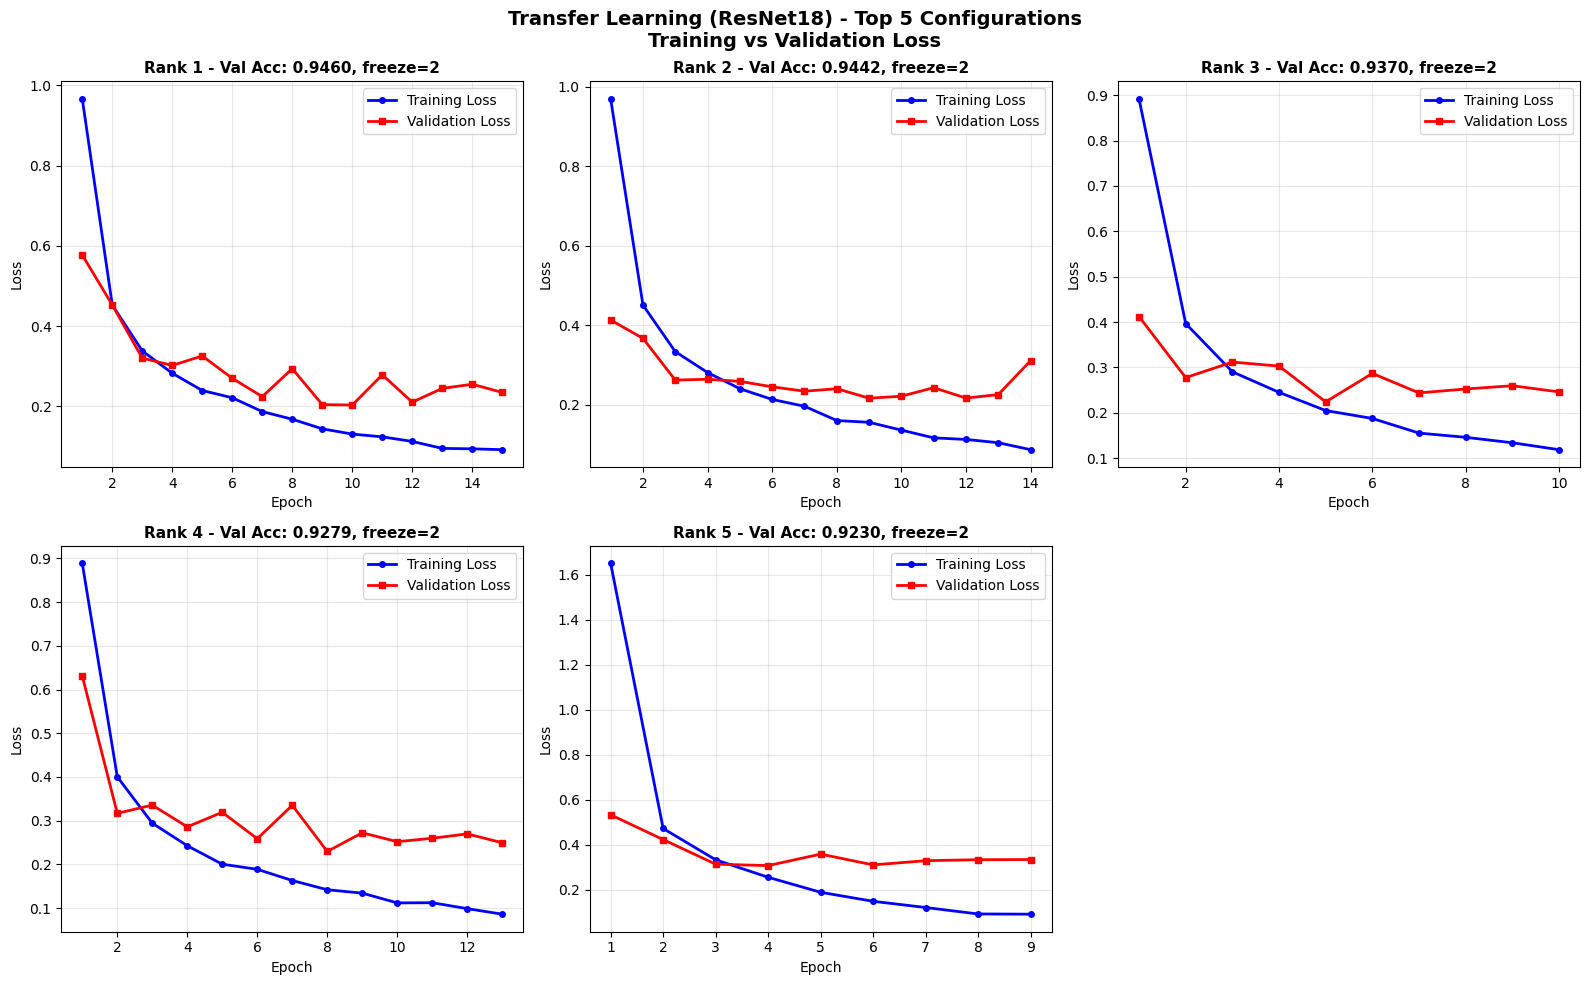

In [6]:
# Plot validation loss curves for top 5
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Transfer Learning (ResNet18) - Top 5 Configurations\nTraining vs Validation Loss', 
             fontsize=14, fontweight='bold')

for idx, history in enumerate(top5_histories):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
    ax.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
    
    rank = idx + 1
    val_acc = tl_top5.iloc[idx]['Val_Acc']
    freeze_info = f", freeze={int(tl_top5.iloc[idx]['freeze_layers'])}" if 'freeze_layers' in tl_top5.columns else ""
    ax.set_title(f'Rank {rank} - Val Acc: {val_acc:.4f}{freeze_info}', fontweight='bold', fontsize=11)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

# Hide unused subplot
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.savefig('transfer_learning_resnet18_validation_loss_curves.png', dpi=300, bbox_inches='tight')
print("✓ Loss curves plot saved as 'transfer_learning_resnet18_validation_loss_curves.png'")
plt.show()

## 5. Save Results

In [7]:
# Create results directory
results_dir = 'transfer_learning_results'
os.makedirs(results_dir, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("\n" + "="*80)
print("SAVING RESULTS".center(80))
print("="*80)

# 1. Save summary CSV with all results
tl_summary_df.to_csv(f'{results_dir}/all_results_{timestamp}.csv', index=False)
print(f"✓ All results saved to: all_results_{timestamp}.csv")

# 2. Save top 5 CSV
tl_top5.to_csv(f'{results_dir}/top5_results_{timestamp}.csv', index=False)
print(f"✓ Top 5 results saved to: top5_results_{timestamp}.csv")

# 3. Save best model info
best_model_info = {
    'model_architecture': 'ResNet18',
    'best_params': tl_results['best_params'],
    'best_val_acc': float(tl_results['best_val_acc']),
    'best_test_acc': float(tl_results['best_test_acc']),
}

with open(f'{results_dir}/best_model_{timestamp}.json', 'w') as f:
    json.dump(best_model_info, f, indent=4, default=str)
print(f"✓ Best model info saved to: best_model_{timestamp}.json")

# 4. Save best model itself
torch.save(tl_results['best_model'].state_dict(), 
           f'{results_dir}/best_model_weights_{timestamp}.pt')
print(f"✓ Best model weights saved to: best_model_weights_{timestamp}.pt")

# 5. Save training history for best model
with open(f'{results_dir}/best_model_history_{timestamp}.pkl', 'wb') as f:
    pickle.dump(tl_results['best_history'], f)
print(f"✓ Best model training history saved to: best_model_history_{timestamp}.pkl")

# 6. Save training histories for top 5
for i, history in enumerate(top5_histories, 1):
    with open(f'{results_dir}/rank_{i:02d}_history_{timestamp}.pkl', 'wb') as f:
        pickle.dump(history, f)
print(f"✓ Top 5 training histories saved")

# 7. Save loss curves data as CSV for easy access
for i, history in enumerate(top5_histories, 1):
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(history['train_loss']) + 1),
        'Train_Loss': history['train_loss'],
        'Val_Loss': history['val_loss'],
        'Train_Acc': history['train_acc'],
        'Val_Acc': history['val_acc'],
    })
    loss_df.to_csv(f'{results_dir}/rank_{i:02d}_loss_curves_{timestamp}.csv', index=False)
print(f"✓ Loss curves data saved as CSV for all top 5")

# 8. Save summary report
total_combinations = len(tl_results['results'])
summary = {
    'model': 'Transfer Learning (ResNet18)',
    'timestamp': timestamp,
    'total_combinations': int(total_combinations),
    'best_val_accuracy': float(tl_results['best_val_acc']),
    'best_test_accuracy': float(tl_results['best_test_acc']),
    'best_hyperparameters': tl_results['best_params'],
    'top5_accuracies': tl_top5['Val_Acc'].tolist(),
}

with open(f'{results_dir}/summary_report_{timestamp}.json', 'w') as f:
    json.dump(summary, f, indent=4, default=str)
print(f"✓ Summary report saved to: summary_report_{timestamp}.json")

print("\n" + "="*80)
print(f"All results saved to: {results_dir}/".center(80))
print("="*80)


                                 SAVING RESULTS                                 
✓ All results saved to: all_results_20251126_040040.csv
✓ Top 5 results saved to: top5_results_20251126_040040.csv
✓ Best model info saved to: best_model_20251126_040040.json
✓ Best model weights saved to: best_model_weights_20251126_040040.pt
✓ Best model training history saved to: best_model_history_20251126_040040.pkl
✓ Top 5 training histories saved
✓ Loss curves data saved as CSV for all top 5
✓ Summary report saved to: summary_report_20251126_040040.json

                All results saved to: transfer_learning_results/                


## 6. Results Summary

In [8]:
print("\n" + "="*80)
print("TRANSFER LEARNING (ResNet18) - TUNING RESULTS SUMMARY".center(80))
print("="*80)

print(f"\nBest Model Performance:")
print(f"  Validation Accuracy: {tl_results['best_val_acc']:.4f}")
print(f"  Test Accuracy: {tl_results['best_test_acc']:.4f}")

print(f"\nBest Hyperparameters:")
for key, value in tl_results['best_params'].items():
    print(f"  {key}: {value}")

# Show frozen layer info for best model
best_freeze = tl_results['best_params'].get('freeze_layers', 0)
print(f"\n📌 Layer Freezing Strategy:")
if best_freeze == 0:
    print(f"  All layers are trainable (full fine-tuning)")
elif best_freeze == 4:
    print(f"  All conv layers frozen (only classifier trained)")
else:
    print(f"  First {best_freeze} residual blocks frozen")

print(f"\nTop 5 Validation Accuracies:")
for rank, (_, row) in enumerate(tl_top5.iterrows(), 1):
    acc = row['Val_Acc']
    freeze = int(row['freeze_layers']) if 'freeze_layers' in row else 'N/A'
    print(f"  Rank {rank}: {acc:.4f} (freeze_layers={freeze})")

total_combinations = len(tl_results['results'])
print(f"\nTotal tuning combinations evaluated: {total_combinations}")
print("\n" + "="*80)


             TRANSFER LEARNING (ResNet18) - TUNING RESULTS SUMMARY              

Best Model Performance:
  Validation Accuracy: 0.9460
  Test Accuracy: 0.9388

Best Hyperparameters:
  learning_rate: 0.001
  batch_size: 32
  num_epochs: 15
  freeze_layers: 2
  dropout: 0.3

📌 Layer Freezing Strategy:
  First 2 residual blocks frozen

Top 5 Validation Accuracies:
  Rank 1: 0.9460 (freeze_layers=2)
  Rank 2: 0.9442 (freeze_layers=2)
  Rank 3: 0.9370 (freeze_layers=2)
  Rank 4: 0.9279 (freeze_layers=2)
  Rank 5: 0.9230 (freeze_layers=2)

Total tuning combinations evaluated: 16



## 7. Best Model Evaluation - Classification Report & Confusion Matrix

Original X_test shape: (5703, 3, 52, 52)
X_test_tensor shape for ResNet18: torch.Size([5703, 3, 52, 52])

CLASSIFICATION REPORT - ResNet18 Transfer Learning BEST MODEL (All 38 Classes)
              precision    recall  f1-score   support

    Class_00     0.9934    1.0000    0.9967       150
    Class_01     0.9434    1.0000    0.9709       150
    Class_02     0.9536    0.9600    0.9568       150
    Class_03     0.9470    0.9533    0.9502       150
    Class_04     0.9074    0.9800    0.9423       150
    Class_05     0.9539    0.9667    0.9603       150
    Class_06     0.9200    1.0000    0.9583        23
    Class_07     0.9470    0.9533    0.9502       150
    Class_08     1.0000    0.9846    0.9922       130
    Class_09     0.9718    0.9200    0.9452       150
    Class_10     0.8663    0.9933    0.9255       150
    Class_11     0.9412    0.9600    0.9505       150
    Class_12     0.9363    0.9800    0.9577       150
    Class_13     0.8854    0.9267    0.9055       150
    

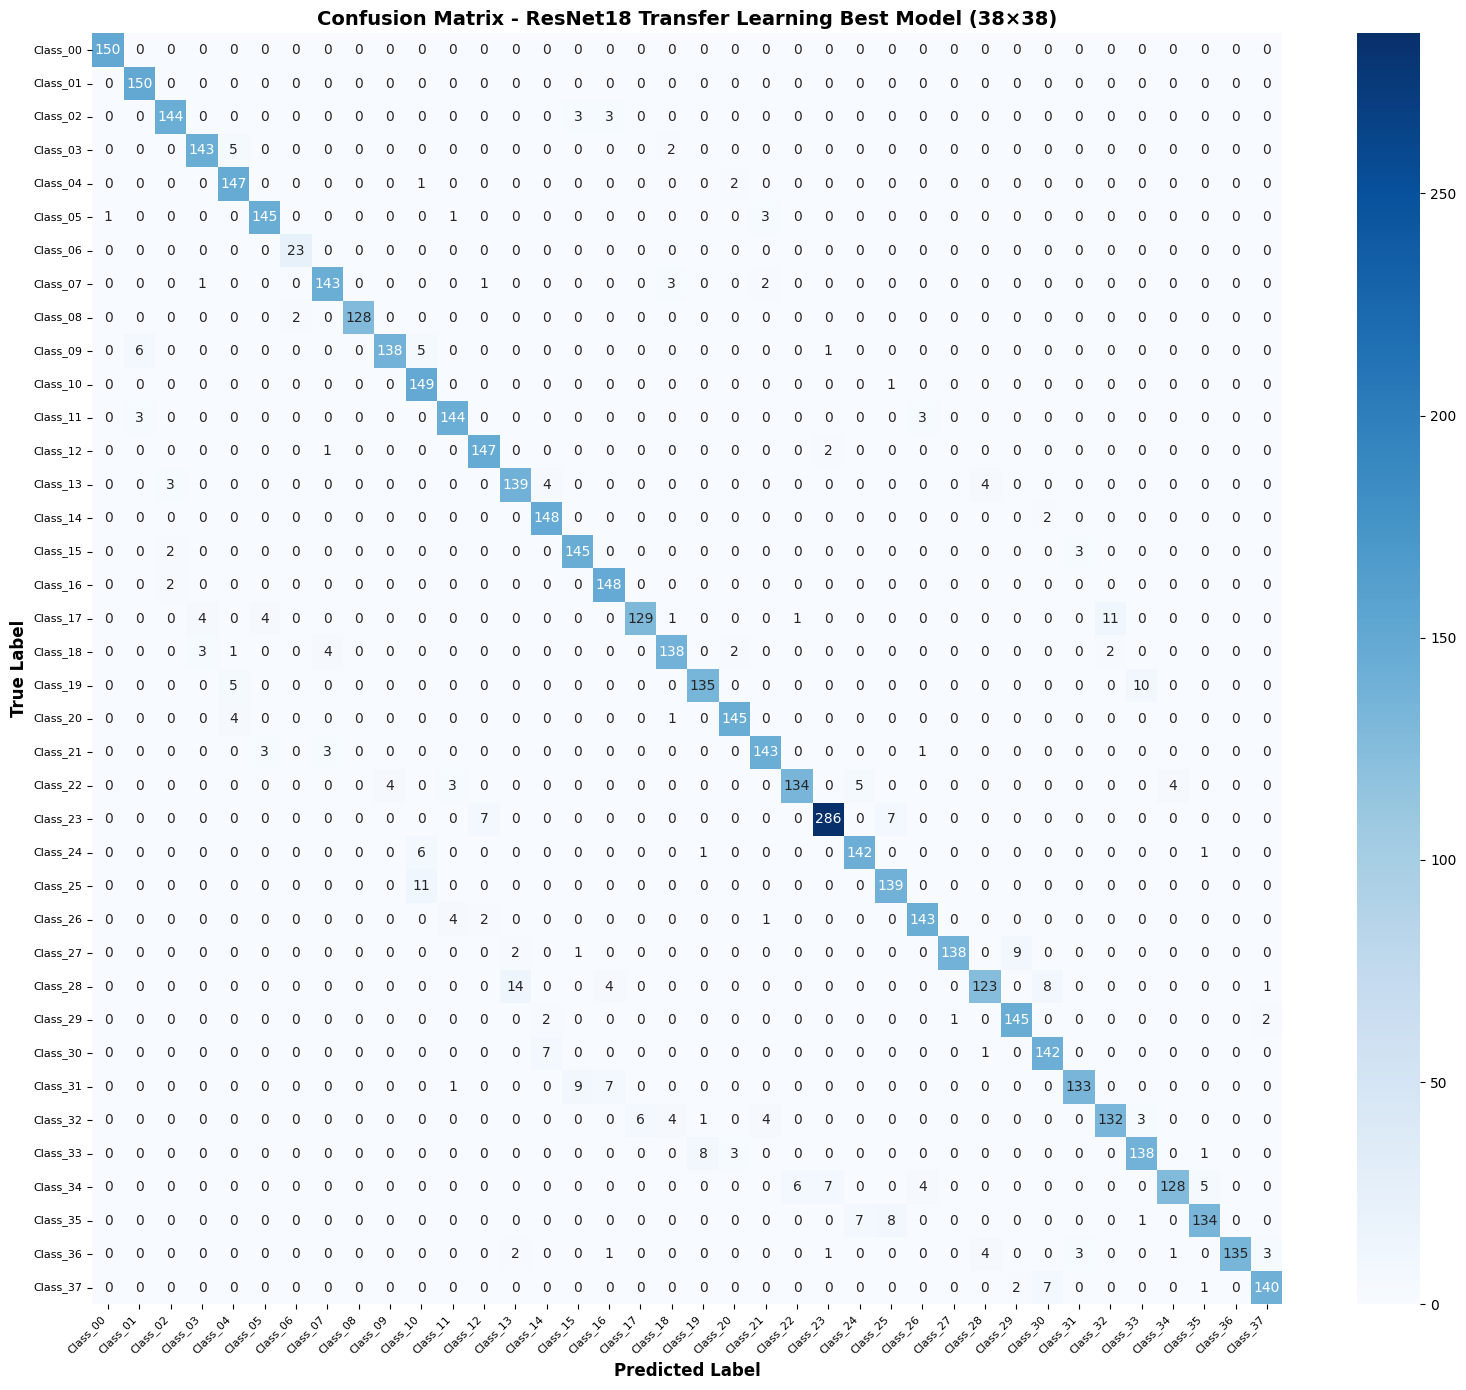


PER-CLASS METRICS SUMMARY
   Class  Precision   Recall  F1-Score  Support  Accuracy
Class_00   0.993377 1.000000  0.996678      150  1.000000
Class_01   0.943396 1.000000  0.970874      150  1.000000
Class_02   0.953642 0.960000  0.956811      150  0.960000
Class_03   0.947020 0.953333  0.950166      150  0.953333
Class_04   0.907407 0.980000  0.942308      150  0.980000
Class_05   0.953947 0.966667  0.960265      150  0.966667
Class_06   0.920000 1.000000  0.958333       23  1.000000
Class_07   0.947020 0.953333  0.950166      150  0.953333
Class_08   1.000000 0.984615  0.992248      130  0.984615
Class_09   0.971831 0.920000  0.945205      150  0.920000
Class_10   0.866279 0.993333  0.925466      150  0.993333
Class_11   0.941176 0.960000  0.950495      150  0.960000
Class_12   0.936306 0.980000  0.957655      150  0.980000
Class_13   0.885350 0.926667  0.905537      150  0.926667
Class_14   0.919255 0.986667  0.951768      150  0.986667
Class_15   0.917722 0.966667  0.941558      1

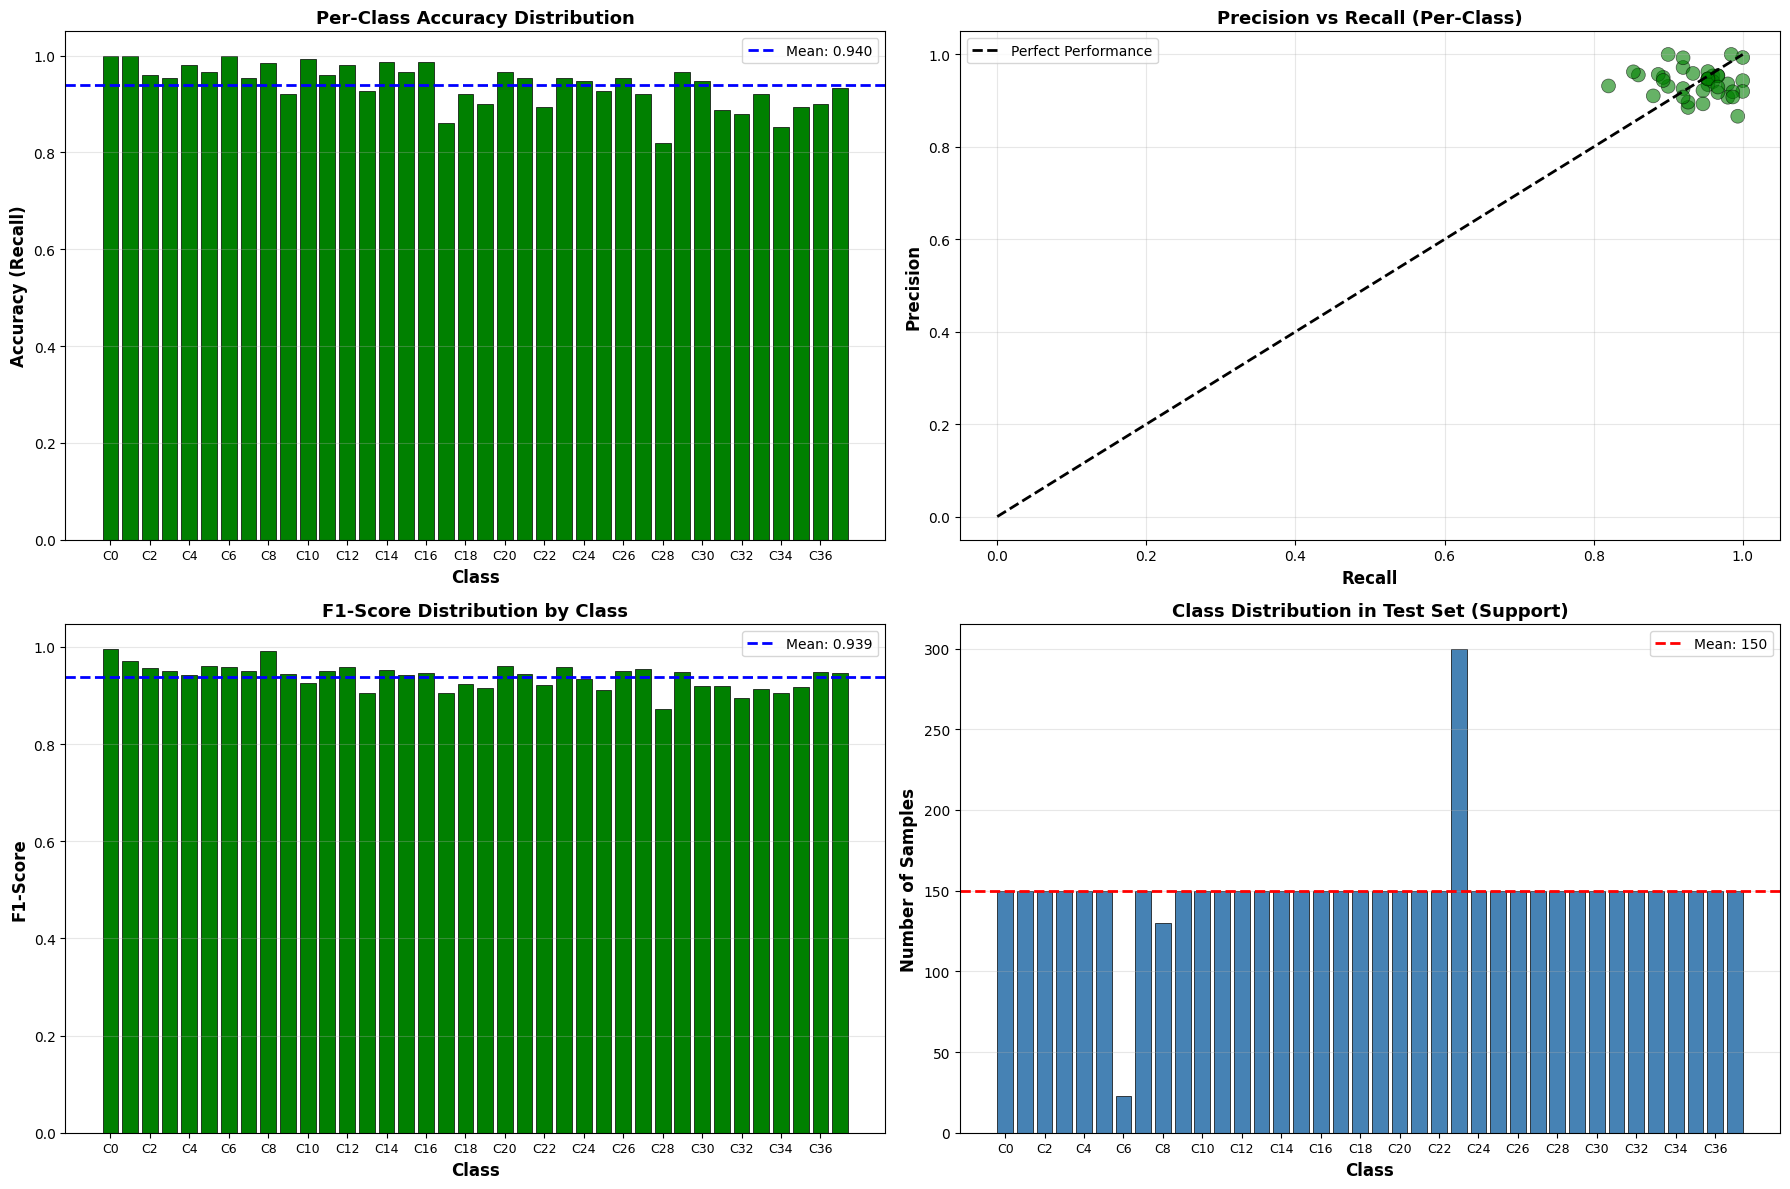


EVALUATION COMPLETE - All results saved successfully


In [9]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from datetime import datetime

# Load best model and generate predictions
best_model = tl_results['best_model']
best_model.eval()

# Debug: Check X_test shape
print(f"Original X_test shape: {X_test.shape}")

# X_test is already 3-channel from preprocessing: (N, 3, 52, 52)
# No need to convert - use directly
X_test_tensor = torch.FloatTensor(X_test).to(device)
print(f"X_test_tensor shape for ResNet18: {X_test_tensor.shape}")

with torch.no_grad():
    logits = best_model(X_test_tensor)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Generate classification report
class_names = [f'Class_{i:02d}' for i in range(38)]
report = classification_report(y_test, predictions, target_names=class_names, digits=4)
print("\n" + "="*80)
print("CLASSIFICATION REPORT - ResNet18 Transfer Learning BEST MODEL (All 38 Classes)")
print("="*80)
print(report)

# Save classification report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
report_path = f'classification_report_resnet18_{timestamp}.txt'
with open(report_path, 'w') as f:
    f.write("CLASSIFICATION REPORT - ResNet18 Transfer Learning BEST MODEL (All 38 Classes)\n")
    f.write("="*80 + "\n")
    f.write(report)
print(f"\n✓ Classification report saved to: {report_path}")

# Compute and visualize confusion matrix
cm = confusion_matrix(y_test, predictions)
print(f"\nConfusion Matrix Shape: {cm.shape}")

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax, 
            xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - ResNet18 Transfer Learning Best Model (38×38)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()

cm_path = f'confusion_matrix_resnet18_{timestamp}.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"✓ Confusion matrix saved to: {cm_path}")
plt.show()

# Extract per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions, labels=range(38))
class_accuracy = recall  # Recall is per-class accuracy

# Create metrics dataframe
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Accuracy': class_accuracy
})

print("\n" + "="*80)
print("PER-CLASS METRICS SUMMARY")
print("="*80)
print(metrics_df.to_string(index=False))

# Save per-class metrics
metrics_path = f'class_wise_metrics_resnet18_{timestamp}.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✓ Per-class metrics saved to: {metrics_path}")

# Print summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Overall Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Macro-Average Precision: {precision.mean():.4f}")
print(f"Macro-Average Recall: {recall.mean():.4f}")
print(f"Macro-Average F1-Score: {f1.mean():.4f}")
print(f"\nBest Performing Classes (Top 5 by F1-Score):")
top_5 = metrics_df.nlargest(5, 'F1-Score')[['Class', 'F1-Score', 'Recall', 'Support']]
print(top_5.to_string(index=False))
print(f"\nWorst Performing Classes (Bottom 5 by F1-Score):")
bottom_5 = metrics_df.nsmallest(5, 'F1-Score')[['Class', 'F1-Score', 'Recall', 'Support']]
print(bottom_5.to_string(index=False))

# Create comprehensive 4-subplot visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Subplot 1: Per-class Accuracy (Recall) with color coding
ax1 = axes[0, 0]
colors_acc = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in class_accuracy]
bars1 = ax1.bar(range(38), class_accuracy, color=colors_acc, edgecolor='black', linewidth=0.5)
ax1.axhline(y=class_accuracy.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {class_accuracy.mean():.3f}')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (Recall)', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Accuracy Distribution', fontsize=13, fontweight='bold')
ax1.set_xticks(range(0, 38, 2))
ax1.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Precision vs Recall Scatter
ax2 = axes[0, 1]
colors_pr = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in class_accuracy]
scatter = ax2.scatter(recall, precision, c=colors_pr, s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Performance')
ax2.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax2.set_title('Precision vs Recall (Per-Class)', fontsize=13, fontweight='bold')
ax2.set_xlim([-0.05, 1.05])
ax2.set_ylim([-0.05, 1.05])
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Subplot 3: F1-Score by Class
ax3 = axes[1, 0]
colors_f1 = ['green' if x >= 0.8 else 'orange' if x >= 0.6 else 'red' for x in f1]
bars3 = ax3.bar(range(38), f1, color=colors_f1, edgecolor='black', linewidth=0.5)
ax3.axhline(y=f1.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.3f}')
ax3.set_xlabel('Class', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('F1-Score Distribution by Class', fontsize=13, fontweight='bold')
ax3.set_xticks(range(0, 38, 2))
ax3.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Support Distribution (Sample Count)
ax4 = axes[1, 1]
bars4 = ax4.bar(range(38), support, color='steelblue', edgecolor='black', linewidth=0.5)
ax4.axhline(y=support.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {support.mean():.0f}')
ax4.set_xlabel('Class', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax4.set_title('Class Distribution in Test Set (Support)', fontsize=13, fontweight='bold')
ax4.set_xticks(range(0, 38, 2))
ax4.set_xticklabels([f'C{i}' for i in range(0, 38, 2)], fontsize=9)
ax4.legend(fontsize=10)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
accuracy_path = f'class_wise_accuracy_resnet18_{timestamp}.png'
plt.savefig(accuracy_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Class-wise accuracy visualization saved to: {accuracy_path}")
plt.show()

print("\n" + "="*80)
print("EVALUATION COMPLETE - All results saved successfully")
print("="*80)